**二维阻尼振荡器**

作为第一个说明性示例，我们考虑具有三次动态的二维阻尼谐振子，即：

$$
\begin{array}{l}
\dot{x} = -0.1\ x^3 + 2.0\ y^3,\\
\dot{y} = -2.0\ x^3 - 0.1\ y^3.
\end{array}
$$

我们使用初始条件 $[x_0\ y_0]^T = [2\ 0]^T$，并从 $t = 0$ 到 $t = 25$ 收集数据，时间步长为 $\Delta t = 0.01$。数据绘制在下图中。我们使用一个具有一层隐藏层和256个神经元的神经网络来表示非线性动力学。对于多步方案，我们采用 $M=1$ 步长的 Adams-Moulton 方法（即梯形规则）。在训练神经网络之后，我们使用与上述相同的初始条件求解识别出的系统。下图定性地评估了识别正确非线性动力学的准确性。具体来说，通过比较系统的精确轨迹和预测轨迹以及所得的相图，我们可以看到算法能够正确捕捉到系统的动态演变。

> _谐振子：_ 左侧面板显示了具有三次动态的二维阻尼谐振子的轨迹，而右侧面板绘制了相应的相图。彩色实线表示精确的动力学，虚线表示学习到的动力学。识别出的系统能够正确捕捉动力学形式，并准确再现相图。

In [34]:
import numpy as np
from scipy.integrate import odeint
from Multistep_NN import Multistep_NN
from plotting import newfig, savefig
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import time

# define solution
sol_fun_1 = lambda x:  (-0.1)* x[:,[0]]**3 + 2 * x[:,[1]]**3 
sol_fun_2 = lambda x:  (-2)* x[:,[0]]**3 + (-0.1) * x[:,[1]]**3 

torch.manual_seed(0)
if __name__ == "__main__": 
    
    # function that returns dx/dt
    def f(x,t): # x is 2 x 1
        A = np.array([[-.1,2], [-2,-.1]]) # 2 x 2
        f = np.matmul(A,x[:,None]**3) # 2 x 1
        return f.flatten()
    
    # time points
    n_steps = 10000
    # t_star = np.arange(0,25,0.01)
    t_star = np.linspace(0, 25, num=n_steps)
    # initial condition
    x0 = np.array([2,0])
    X_star = odeint(f, x0, t_star)
    noise = 0.00

    skip = 1
    dt = t_star[skip] - t_star[0]
    X_train = X_star[0::skip,:]
    X_train = X_train + noise*X_train.std(0)*np.random.randn(X_train.shape[0], X_train.shape[1])
    
    X_train = np.reshape(X_train, (1,X_train.shape[0],X_train.shape[1]))
    layers = [2, 29, 2]
    
    M = 1
    scheme = 'AM'
    model = Multistep_NN(dt, X_train, layers, M, scheme)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001,betas=(0.9, 0.999),  eps=1e-32)
    N_Iter = 5001
    
    times = []
    Train_loss_list = []
    iteration_list = []
    target_loss = 1e-10

    start_time = time.time()
    for epoch in range(N_Iter):
        model.train()       
        optimizer.zero_grad()
        Y_pred = model.forward(model.X)
        # loss = self.D * loss_function(Y_pred, torch.zeros_like(Y_pred))
        loss = loss_function(Y_pred, torch.zeros_like(Y_pred))
        loss.backward()
        optimizer.step()
        current_time = time.time()
        iteration_time = current_time - start_time

            # 存储损失值和迭代次数
        times.append(iteration_time)
        Train_loss_list.append(loss.cpu().detach().numpy())
        iteration_list.append(epoch)
            
        # Print
        if epoch % 1000 == 0:
            print(f'Epoch {epoch+1}/{N_Iter}, Train_loss: {loss.item(): .16e}, Time per iteration: {iteration_time:.4f} seconds')

        if loss.item() < target_loss:
            print(f'Target loss reached at iteration {epoch+1}.')
            break    


    def learned_f(x,t):
        f = model.predict_f(x[None,:])
        return f.flatten()
    
    learned_X_star = odeint(learned_f, x0, t_star)    
    

Epoch 1/5001, Train_loss:  2.1389254470705055e-05, Time per iteration: 0.0050 seconds
Epoch 1001/5001, Train_loss:  7.1899185059010051e-06, Time per iteration: 5.4819 seconds
Epoch 2001/5001, Train_loss:  1.0288399607816245e-06, Time per iteration: 10.8014 seconds
Epoch 3001/5001, Train_loss:  1.1198100224873997e-07, Time per iteration: 15.8309 seconds
Epoch 4001/5001, Train_loss:  3.8783188216484632e-08, Time per iteration: 20.9750 seconds
Epoch 5001/5001, Train_loss:  1.8315178706984625e-08, Time per iteration: 25.9921 seconds


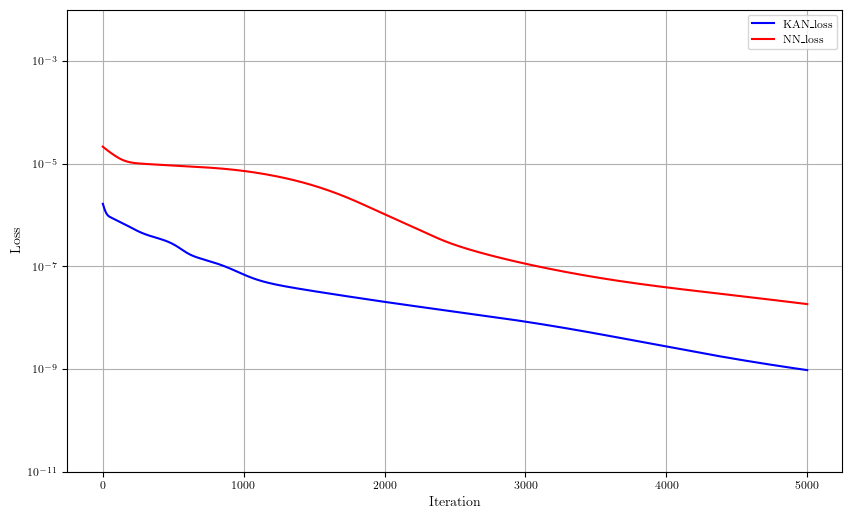

In [36]:
data = np.genfromtxt('loss_time_data_5000_0.001.csv', delimiter=',', skip_header=1)


# 绘制迭代次数和误差的关系图
plt.figure(figsize=(10, 6))
# plt.plot(data[:2001,0], data[:2001,1], label='Train loss', color='b')
# plt.plot(iteration_list[:2001], Train_loss_list[:2001], label='Train loss', color='r')
plt.plot(data[:,0], data[:,1], label='KAN_loss', color='b')
plt.plot(iteration_list, Train_loss_list, label='NN_loss', color='r')
plt.yscale('log')
plt.ylim(10e-12, 10e-3)
plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.title('Loss vs. Iteration')
plt.legend()
plt.grid(True)
# plt.show()
plt.savefig('Cubic2D_Error_5000_0.001.png', format='png', dpi=600, bbox_inches='tight')

In [ ]:
# 绘制时间和误差的关系图
plt.figure(figsize=(10, 5))
plt.plot(times, Train_loss_list, label='Loss vs Time')
plt.yscale('log')
plt.xlabel('Time (seconds)')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

In [ ]:
####### Plotting ################## 
plt.figure(figsize=(10, 6))
plt.plot(t_star, learned_X_star[:,0], label='learned_y_1',linestyle='--', color='r')
plt.plot(t_star, learned_X_star[:,1], label='learned_y_2',linestyle='--', color='b')
plt.plot(t_star, X_star[:,0], label='y_1', color='g')
plt.plot(t_star, X_star[:,1], label='y_2', color='c')
plt.legend()
plt.show

In [ ]:
####### Plotting ################## 
fig, ax = newfig(1.0, 0.9)
ax.axis('off')

gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=0.85, bottom=0.25, left=0.1, right=0.95, wspace=0.3)

ax = plt.subplot(gs0[:, 0:1])
ax.plot(t_star,X_star[:,0],'r',label='$x$')
ax.plot(t_star,X_star[:,1],'b',label='$y$')
ax.plot(t_star,learned_X_star[:,0],'k--',label='learned model')
ax.plot(t_star,learned_X_star[:,1],'k--')    
ax.set_xlabel('$t$')
ax.set_ylabel('$x, y$')
ax.legend(loc='upper center', bbox_to_anchor=(0.9, -0.25), ncol=3, frameon=False)
ax.set_title('Trajectories', fontsize = 10)

ax = plt.subplot(gs0[:, 1:2])
ax.plot(X_star[:,0],X_star[:,1], 'm', label='$(x,y)$')
ax.plot(learned_X_star[:,0],learned_X_star[:,1],'k--')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc='upper center', bbox_to_anchor=(0.4, -0.25), ncol=1, frameon=False)
ax.set_title('Phase Portrait', fontsize = 10)

savefig('./figures/Cubic2D')